In [27]:
from imutils import face_utils
from imutils import paths
import numpy as np
import imutils
import argparse 
import imutils
import time
import dlib
import cv2
import os 
import matplotlib.pyplot as plt
import scipy
from scipy import signal as sp
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [3]:
# read the txt file where the files to read are mentioned
file = open('file-to-read.txt')
filenames = file.read().splitlines()


# Depending on weather the video file was split or not, the path would be different
#path_to_file = "../../../Documents/thermal-project-data/cycling/split/"
path_to_file = "../../../Documents/thermal-project-data/cycling/"


def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(50,50), maxLevel=16, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))
    

# keep a count of frames in total across all the videos.
frameCount = 0

# list to store all the ROI's sum of pixels for each frame of each video
rrSignal = []

for file in filenames:
    full_path = os.path.join(path_to_file+file)

    cap = cv2.VideoCapture(full_path)
    
    # get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)

    # read the first frame of the video
    correct,frame = cap.read()
    
    if not correct:
        break;

    # convert the first frame to grayscale
    old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    # show the first frame. imshow requires param to be in BGR format unlike Matplotlib's RGB
    cv2.imshow('image', frame)
    #b,g,r = cv2.split(frame)
    #frame = cv2.merge((r,g,b))

    # hook the function to be called in case of mouse click
    cv2.setMouseCallback('image', click_event)

    # wait infinitely until a key is pressed.
    cv2.waitKey(0)
    
    while True:
        sumPixels = 0;

        # read the second frame
        correct, frame = cap.read()
        if not correct:
            break;
        frameCount+=1

        # get the size of the frame
        height, width, channel = frame.shape

        # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
        mask = np.zeros((height, width), np.uint8)

        # convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # get the new points for optical flow
        new_points, status, error = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, old_points, None, **lk_param)
        # update the old frame to the current frame
        old_gray = gray_frame.copy()
        # update the old points to new points
        old_points = new_points

        # make arrangements to plot the points
        x,y = new_points.ravel()
        x_i, y_i = first_point.ravel()

        # draw the point where the initial click was made
        cv2.circle(frame, (int(x_i),int(y_i)),5,(0,0,255),-1)

        circleRadius = 25
        # draw the moving point as per optical flows
        cv2.circle(frame, (int(x),int(y)),circleRadius,(255,0,0),-1)

        # create the circle with new point over the mask as well
        circle_mask = cv2.circle(mask, (int(x), int(y)),circleRadius,(255,0,0),-1)
        masked_data = cv2.bitwise_and(gray_frame,gray_frame,mask=circle_mask)

        # code to get all pixel location inside the ROI in the optical flow
        tom, thres = cv2.threshold(mask, 1,255, cv2.THRESH_BINARY)
        contours = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(contours[0][0])
        crop = masked_data[y:y+h,x:x+w]
        
        #print(np.sum(crop[:,:]))

        # now that we have the pixels corresponding to the ROI, lets sum of all pixels.
        sumPixels = np.sum(crop[:,:])

        # for each frame, store the sumPixel in an array. This array is the signal for RR
        rrSignal.append(sumPixels)


        cv2.imshow("Frame", frame)
        key = cv2.waitKey(int((1/fps)*1000))
        if key == 27 or key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
rrSignal_t = [f/fps for f in range(1,frameCount)]    

In [8]:
len(rrSignal_t)

269

In [10]:
len(filteredA[:-1])

269

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


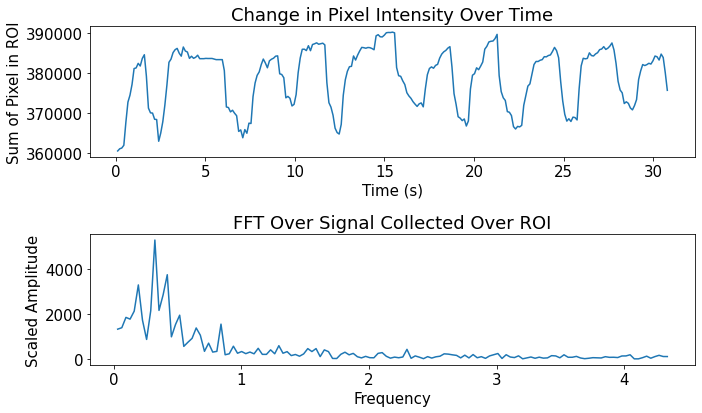

In [28]:
# show the respiration rate
size = 4
window = sp.gaussian(M=size, std=6)
window /= window.sum()
filteredA = np.convolve(np.array(rrSignal), window, mode='same')
F,A = compute_fft(rrSignal, fps, n = None, scale_amplitudes = True)

fig, ax  = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(rrSignal_t,rrSignal[:-1])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Sum of Pixel in ROI')
ax[0].set_title('Change in Pixel Intensity Over Time')
#ax[1].plot(rrSignal_t,filteredA[:-1])
ax[1].plot(F[1:],A[1:])
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Scaled Amplitude')
ax[1].set_title('FFT Over Signal Collected Over ROI')

fig.tight_layout()

18.0
20.1
21.8
65.5


(0.0, 70.0)

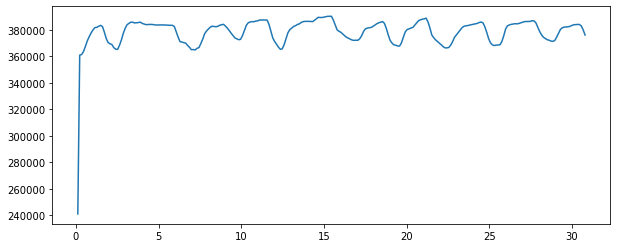

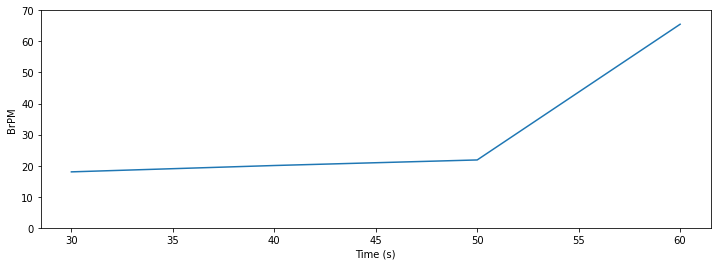

In [11]:



# store the end timestamp in second at which the BrPM computation was ready
indices = [] 
BrPMList = []
for i in range(0,round(rrSignal_t[-1]),10):
    if i+30 > 300: #TODO: Need to address what this 300 is? 
        print("Reached End")
        break;
    F,A = compute_fft(filteredA[int(i*fps): int((i+30)*fps)], fps, n = None, scale_amplitudes = True)
    highestFreq = F[np.argmax(A[1:])+1]
    indices.append(i+30)
    #print("Breathing Rate {} to {} = {:.2f}".format(i,i+10,highestFreq*60));
    #print("{}-{}--{:.1f}".format(i,i+30,highestFreq*60))
    BrPMList.append(highestFreq*60)
    print("{:.1f}".format(highestFreq*60))

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(indices,BrPMList)
ax.set_xlabel('Time (s)')
ax.set_ylabel('BrPM')
ax.set_ylim((0,70))

    


In [3]:
# Code to get the first frame and save it as an image

# no longer required to be executed as it is apparent that the first frame is not useful to get facial landmarks.

'''
vidcap = cv2.VideoCapture("../../../Documents/thermal-project-data/cycling/split/09212022_2-clip0.MP4")
success,image = vidcap.read()
count = 0

while success:
    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1
    success = False
'''

Read a new frame:  True


In [ ]:
# End of active script in use

In [53]:
# OLD CODE FOR ONE FILE ONLY

# reads a frame of an image
# returns the (x,y) coordinate of the image on which the image was clicked

#opencv: BGR
#matplotlib: RGB


def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(200,200), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))
    


path = "../../../Documents/thermal-project-data/cycling/split"
filename = "09212022_2-clip0.MP4" 
fullpath = os.path.join(path, filename)

print(fullpath)
#cap = cv2.VideoCapture("../../../Documents/thermal-project-data/cycling/split/09212022_2-clip0.MP4")
cap = cv2.VideoCapture(fullpath)
# get the frame rate
fps = cap.get(cv2.CAP_PROP_FPS)

# read the first frame of the video
correct,frame = cap.read()

if not correct:
    print("File Load Failed")

# convert the first frame to grayscale
old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

# show the first frame. imshow requires param to be in BGR format unlike Matplotlib's RGB
cv2.imshow('image', frame)
#b,g,r = cv2.split(frame)
#frame = cv2.merge((r,g,b))

# hook the function to be called in case of mouse click
cv2.setMouseCallback('image', click_event)

# wait infinitely until a key is pressed.
cv2.waitKey(0)

# list to store all the ROI's sum of pixels for each frame
rrSignal = []

# keep a count of frames so that we know the timestamp
frameCount = 1

while True:
    sumPixels = 0;
    
    # read the second frame
    correct, frame = cap.read()
    if not correct:
        break;
    frameCount+=1
    
    # get the size of the frame
    height, width, channel = frame.shape

    # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
    mask = np.zeros((height, width), np.uint8)
        
    # convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    # get the new points for optical flow
    new_points, status, error = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, old_points, None, **lk_param)
    # update the old frame to the current frame
    old_gray = gray_frame.copy()
    # update the old points to new points
    old_points = new_points
    
    # make arrangements to plot the points
    x,y = new_points.ravel()
    x_i, y_i = first_point.ravel()
    
    # draw the point where the initial click was made
    cv2.circle(frame, (int(x_i),int(y_i)),5,(0,0,255),-1)
    
    circleRadius = 25
    # draw the moving point as per optical flows
    cv2.circle(frame, (int(x),int(y)),circleRadius,(255,0,0),-1)
    
    # create the circle with new point over the mask as well
    circle_mask = cv2.circle(mask, (int(x), int(y)),circleRadius,(255,0,0),-1)
    masked_data = cv2.bitwise_and(gray_frame,gray_frame,mask=circle_mask)
    
    # code to get all pixel location inside the ROI in the optical flow
    tom, thres = cv2.threshold(mask, 1,255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0][0])
    crop = masked_data[y:y+h,x:x+w]
    
    # now that we have the pixels corresponding to the ROI, lets sum of all pixels.
    sumPixels = np.sum(crop[:,:])
    
    # for each frame, store the sumPixel in an array. This array is the signal for RR
    rrSignal.append(sumPixels)
    
    
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(int((1/fps)*1000))
    if key == 27 or key == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

rrSignal_t = [f/fps for f in range(1,frameCount)]

print("Playback Over")



../../../Documents/thermal-project-data/cycling/split/09212022_2-clip0.MP4
Playback Over


0-30--75.2
Breathing Rate Computed From Entire Signal


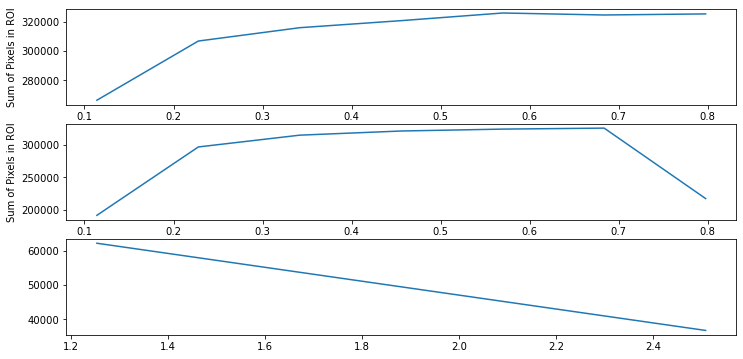

In [8]:
# clean the signal using a Gaussina filter
size = 3
window = sp.gaussian(M=size, std=6)
window /= window.sum()
filteredA = np.convolve(np.array(rrSignal), window, mode='same')


for i in range(0,round(rrSignal_t[-1]),10):
    #perform FFT on the signal
    F,A = compute_fft(filteredA[int(i*fps): int((i+30)*fps)], fps, n = None, scale_amplitudes = True)
    highestFreq = F[np.argmax(A[1:])+1]
    #print("Breathing Rate {} to {} = {:.2f}".format(i,i+10,highestFreq*60));
    print("{}-{}--{:.1f}".format(i,i+30,highestFreq*60))
    if i+30 == 60:
        break

print("Breathing Rate Computed From Entire Signal")

fig, ax = plt.subplots(3,1,figsize=(12,6))
ax[0].plot(rrSignal_t,rrSignal)
ax[1].plot(rrSignal_t,filteredA)
ax[2].plot(F[1:],A[1:])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Sum of Pixels in ROI')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Sum of Pixels in ROI');


In [19]:
# old implementation

'''

cap = cv2.VideoCapture("../../../Downloads/09162022_17.qt")

#cap = cv2.VideoCapture(0)
fps = cap.get(cv2.CAP_PROP_FPS)
print("Frame Rate = {}".format(fps))

# create old frame
_,frame = cap.read()
old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)


# lucas kanade params
lk_param = dict(winSize=(45,45), maxLevel=4, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))

def select_point(event, x ,y, flags, param):
    global point, point_selected, old_points;
    if event == cv2.EVENT_LBUTTONDOWN:
        point = (x,y)
        point_selected=True
        old_points = np.array([[x,y,]], dtype=np.float32)
        

        
        
cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", select_point)
point_selected = False;
point = ()   
old_points = np.array([[]])


while True:
    correct, frame = cap.read()
    if not correct:
        break;
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    if point_selected is True:
        cv2.circle(frame, point, 5, (0, 0, 255), 2) #BGR Format
        
        new_points, status, error = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, old_points, None, **lk_param) 
        old_gray = gray_frame.copy()
        old_points = new_points
        x,y = new_points.ravel()
        cv2.circle(frame, (int(x),int(y)),5,(0,255,0),-1)
        
        
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(int((1/fps)*1000))
    if key == 27 or key == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
#cv2.waitKey(1)

'''

Frame Rate = 8.766603415559773
